<a href="https://colab.research.google.com/github/prakashradhakrish/Distilling-the-knowledge-in-a-Neural-Network/blob/master/RP13_Knowledgedistillation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ***KNOWLEDGE DISTILLATION _ RP team 13***


---
#![alt text](https://drive.google.com/uc?id=1QP4Cpi-CIGLc6kEUYmEIWkOSb3gh7Lzf)


---






# ***Initialisation of the libraries***

In [0]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms,datasets
import numpy as np
import os
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

# ***Dataset***

---
Loading dataset with transformation


In [0]:
!git clone http://github.com/pytorch/examples
os.chdir('examples/mnist')

Cloning into 'examples'...
remote: Enumerating objects: 2333, done.
remote: Total 2333 (delta 0), reused 0 (delta 0), pack-reused 2333
Receiving objects: 100% (2333/2333), 39.02 MiB | 10.58 MiB/s, done.
Resolving deltas: 100% (1172/1172), done.


In [0]:
# Transforming the dataset to tensors and translation is added to the dataset
transformtrain= transforms.Compose([transforms.RandomAffine(0, translate=(0.07,0)),transforms.ToTensor()])
transform = transforms.Compose([transforms.ToTensor()])

# Downlading the training set(transformation applied only to trainset) and test set 
trainset = datasets.MNIST(root='/content/examples/data', download=True, transform=transformtrain)
testset = datasets.MNIST(root='/content/examples/data', download=True, transform=transform, train=False)

# Batchsize of 100 used for loader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=True, num_workers=2)

print(len(trainset), len(testset))

Extracting /content/examples/data/MNIST/raw/train-images-idx3-ubyte.gz to /content/examples/data/MNIST/raw


Extracting /content/examples/data/MNIST/raw/train-labels-idx1-ubyte.gz to /content/examples/data/MNIST/raw


Extracting /content/examples/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/examples/data/MNIST/raw


Extracting /content/examples/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/examples/data/MNIST/raw
Processing...
Done!
60000 10000


# ***Network architecture***

---
Defining the model architecture of the **teacher and student network**


1.   TeacherNetwork - 2 hidden layer 1200 units
2.   StudentNetwork - 2 hidden layer 800 units
3.   StudentNetwork_small - 2 hidden layer 300 units
4.   StudentNetwork_mini - 2 hidden layer 30 units






In [0]:
use_gpu = torch.cuda.is_available()

class TeacherNetwork(nn.Module):
    def __init__(self):
        super(TeacherNetwork, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 1200)
        self.fc2 = nn.Linear(1200, 1200)
        self.fc3 = nn.Linear(1200, 10)
        self.dropout_input = 0.0
        self.dropout_hidden = 0.0
        self.is_training = True
    
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.dropout(x, p=self.dropout_input, training=self.is_training)
        x = F.dropout(F.relu(self.fc1(x)), p=self.dropout_hidden, training=self.is_training)
        x = F.dropout(F.relu(self.fc2(x)), p=self.dropout_hidden, training=self.is_training)
        x = self.fc3(x)
        return x
  

class StudentNetwork(nn.Module):
    def __init__(self):
        super(StudentNetwork, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 800)
        self.fc2 = nn.Linear(800, 800)
        self.fc3 = nn.Linear(800, 10)
        self.dropout_input = 0.0
        self.dropout_hidden = 0.0
        self.is_training = True
    
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.dropout(x, p=self.dropout_input, training=self.is_training)
        x = F.dropout(F.relu(self.fc1(x)), p=self.dropout_hidden, training=self.is_training)
        x = F.dropout(F.relu(self.fc2(x)), p=self.dropout_hidden, training=self.is_training)
        x = self.fc3(x)
        return x

class StudentNetwork_small(nn.Module):
    def __init__(self):
        super(StudentNetwork_small, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 300)
        self.fc2 = nn.Linear(300, 300)
        self.fc3 = nn.Linear(300, 10)
        self.dropout_input = 0.0
        self.dropout_hidden = 0.0
        self.is_training = True
    
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.dropout(x, p=self.dropout_input, training=self.is_training)
        x = F.dropout(F.relu(self.fc1(x)), p=self.dropout_hidden, training=self.is_training)
        x = F.dropout(F.relu(self.fc2(x)), p=self.dropout_hidden, training=self.is_training)
        x = self.fc3(x)
        return x


class StudentNetwork_mini(nn.Module):
    def __init__(self):
        super(StudentNetwork_mini, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 30)
        self.fc2 = nn.Linear(30, 30)
        self.fc3 = nn.Linear(30, 10)
        self.dropout_input = 0.0
        self.dropout_hidden = 0.0
        self.is_training = True
    
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.dropout(x, p=self.dropout_input, training=self.is_training)
        x = F.dropout(F.relu(self.fc1(x)), p=self.dropout_hidden, training=self.is_training)
        x = F.dropout(F.relu(self.fc2(x)), p=self.dropout_hidden, training=self.is_training)
        x = self.fc3(x)
        return x



# ***Learning teacher network***

---



In [0]:
teacherNetwork = TeacherNetwork() 
if use_gpu:
    teacherNetwork = teacherNetwork.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(teacherNetwork.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-5) 
scheduler = StepLR(optimizer, step_size=30, gamma=0.1) 

**Training Teacher model**

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


[1,   600] loss: 4.155
[2,   600] loss: 1.568
[3,   600] loss: 1.046
[4,   600] loss: 0.792
[5,   600] loss: 0.651
[6,   600] loss: 0.551
[7,   600] loss: 0.489
[8,   600] loss: 0.442
[9,   600] loss: 0.395
[10,   600] loss: 0.360
[11,   600] loss: 0.325
[12,   600] loss: 0.305
[13,   600] loss: 0.283
[14,   600] loss: 0.265
[15,   600] loss: 0.249
[16,   600] loss: 0.225
[17,   600] loss: 0.217
[18,   600] loss: 0.205
[19,   600] loss: 0.193
[20,   600] loss: 0.174
[21,   600] loss: 0.177
[22,   600] loss: 0.165
[23,   600] loss: 0.153
[24,   600] loss: 0.153
[25,   600] loss: 0.142
[26,   600] loss: 0.138
[27,   600] loss: 0.119
[28,   600] loss: 0.122
[29,   600] loss: 0.114
[30,   600] loss: 0.090
[31,   600] loss: 0.077
[32,   600] loss: 0.077
[33,   600] loss: 0.081
[34,   600] loss: 0.074
[35,   600] loss: 0.075
[36,   600] loss: 0.077
[37,   600] loss: 0.069
[38,   600] loss: 0.069
[39,   600] loss: 0.072
[40,   600] loss: 0.070
[41,   600] loss: 0.069
[42,   600] loss: 0.069
[

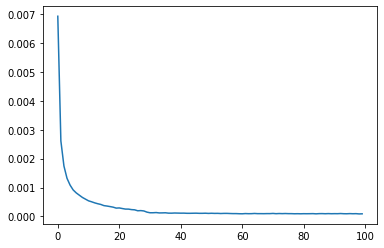

In [0]:
loss_values =[]

for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    scheduler.step()
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = teacherNetwork (inputs)
        loss = criterion(outputs, labels)

        #loss += lmbd * reg_loss
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 600 == 599:    
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 100))
            loss_values.append(running_loss / len(trainset))
            running_loss = 0.0
plt.plot(loss_values)
print('Finished Training')

**Evaluating Teacher model on test data**

In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = teacherNetwork(images.cuda())
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum().item()
        if total % 1000 == 999:    # print every 1000 mini-batches
            print('[%5d] completed' %(total + 1))
            

print('Accuracy of the network on the 10000 test images: %.2f %%' % (
    100 * correct / total))
wrong_pred = total-correct;
print('wrong prediction of the network on the 10000 test images:', wrong_pred,'out of',total)

Accuracy of the network on the 10000 test images: 98.81 %
wrong prediction of the network on the 10000 test images: 119 out of 10000


# ***Learning Student network***

---
1. Without knowledge distillation
2. With knowledge distillation using soft target of trained teacher model



***1. Without knowledge distillation***


---




In [0]:
studentnetwork_wodist = StudentNetwork()    

if use_gpu:
    studentnetwork_wodist = studentnetwork_wodist.cuda()
optimizer1 = optim.SGD(studentnetwork_wodist.parameters(), lr=1e-2, momentum=0.9) 
scheduler = StepLR(optimizer1, step_size=30, gamma=0.1) 

**Training student network without distillation**

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


[1,   100] loss: 1.880
[1,   200] loss: 0.706
[1,   300] loss: 0.524
[1,   400] loss: 0.452
[1,   500] loss: 0.411
[1,   600] loss: 0.356
[2,   100] loss: 0.322
[2,   200] loss: 0.314
[2,   300] loss: 0.277
[2,   400] loss: 0.267
[2,   500] loss: 0.233
[2,   600] loss: 0.223
[3,   100] loss: 0.199
[3,   200] loss: 0.202
[3,   300] loss: 0.177
[3,   400] loss: 0.179
[3,   500] loss: 0.166
[3,   600] loss: 0.160
[4,   100] loss: 0.145
[4,   200] loss: 0.154
[4,   300] loss: 0.145
[4,   400] loss: 0.131
[4,   500] loss: 0.125
[4,   600] loss: 0.120
[5,   100] loss: 0.117
[5,   200] loss: 0.124
[5,   300] loss: 0.111
[5,   400] loss: 0.110
[5,   500] loss: 0.105
[5,   600] loss: 0.103
[6,   100] loss: 0.099
[6,   200] loss: 0.100
[6,   300] loss: 0.097
[6,   400] loss: 0.089
[6,   500] loss: 0.088
[6,   600] loss: 0.099
[7,   100] loss: 0.086
[7,   200] loss: 0.082
[7,   300] loss: 0.084
[7,   400] loss: 0.090
[7,   500] loss: 0.084
[7,   600] loss: 0.083
[8,   100] loss: 0.082
[8,   200] 

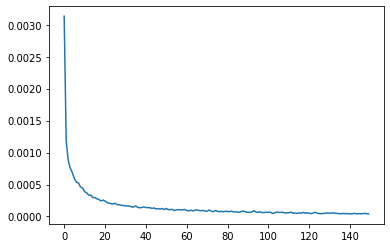

In [0]:
loss_values =[]
for epoch in range(25):  # loop over the dataset multiple times

    running_loss = 0.0
    scheduler.step()
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
        # zero the parameter gradients
        optimizer1.zero_grad()

        # forward + backward + optimize
        output_student = studentnetwork_wodist(inputs)
        loss = criterion(output_student, labels)
        loss.backward()
        optimizer1.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 100))
            loss_values.append(running_loss / len(trainset))
            running_loss = 0.0
plt.plot(loss_values)
print('Finished Training')

**Testing student network without distillation**

In [0]:
# result without knowledge distillation
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = studentnetwork_wodist(images.cuda())
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum().item()
        if total % 1000 == 999:    # print every 1000 mini-batches
            print('[%5d] completed' %(total + 1))
            

print('Accuracy of the network on the 10000 test images: %.2f %%' % (
    100 * correct / total))
wrong_pred = total-correct;
print('wrong prediction of the network on the 10000 test images:', wrong_pred,'out of',total)

Accuracy of the network on the 10000 test images: 98.68 %
wrong prediction of the network on the 10000 test images: 132 out of 10000


***2. With knowledge distillation***



---




In [0]:
studentnetwork_distil = StudentNetwork()  

if use_gpu:
    studentnetwork_distil = studentnetwork_distil.cuda()

optimizer2 = optim.SGD(studentnetwork_distil .parameters(),  lr=1e-2, momentum=0.9)
T=20 #Temperature is initially set as 20
l = 0.3;
scheduler = StepLR(optimizer2, step_size=30, gamma=0.1) 

**Training student network with distillation**

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


[1,   100] loss: 15.484
[1,   200] loss: 3.916
[1,   300] loss: 1.893
[1,   400] loss: 1.120
[1,   500] loss: 0.782
[1,   600] loss: 0.600
[2,   100] loss: 0.457
[2,   200] loss: 0.384
[2,   300] loss: 0.326
[2,   400] loss: 0.300
[2,   500] loss: 0.263
[2,   600] loss: 0.235
[3,   100] loss: 0.208
[3,   200] loss: 0.199
[3,   300] loss: 0.187
[3,   400] loss: 0.182
[3,   500] loss: 0.170
[3,   600] loss: 0.161
[4,   100] loss: 0.152
[4,   200] loss: 0.150
[4,   300] loss: 0.141
[4,   400] loss: 0.140
[4,   500] loss: 0.138
[4,   600] loss: 0.131
[5,   100] loss: 0.126
[5,   200] loss: 0.120
[5,   300] loss: 0.120
[5,   400] loss: 0.123
[5,   500] loss: 0.118
[5,   600] loss: 0.113
[6,   100] loss: 0.109
[6,   200] loss: 0.110
[6,   300] loss: 0.105
[6,   400] loss: 0.102
[6,   500] loss: 0.108
[6,   600] loss: 0.104
[7,   100] loss: 0.095
[7,   200] loss: 0.094
[7,   300] loss: 0.099
[7,   400] loss: 0.096
[7,   500] loss: 0.094
[7,   600] loss: 0.095
[8,   100] loss: 0.091
[8,   200]

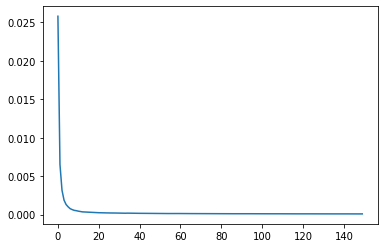

In [0]:
loss_values =[]
for epoch in range(25):  # loop over the dataset multiple times

    running_loss = 0.0
    scheduler.step()
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
        # zero the parameter gradients
        optimizer2.zero_grad()

        # forward + backward + optimize
        output_teacher = teacherNetwork(inputs)
        _, predicted_teacher = torch.max(output_teacher, 1)
        output_student = studentnetwork_distil  (inputs)
        _, predicted_student = torch.max(output_student, 1)
        
        #To implement the softmax principle of knowledge distiallation of teacher model into the student.
        loss1 = F.kl_div(torch.nn.functional.log_softmax(output_student/T,dim=1),torch.nn.functional.softmax(output_teacher/T,dim=1), reduction='batchmean')
        loss2 = criterion(output_student,labels)
        loss = ((1-l)*loss1*(T**2)) + (l * loss2)
        loss.backward()
        optimizer2.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            loss_values.append(running_loss / len(trainset))
            running_loss = 0.0
            
plt.plot(loss_values)
print('Finished Training')

**Testing student network with distillation**




In [0]:
# Implementation of soft max and hard target checks
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = studentnetwork_distil (images.cuda())
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum().item()
        if total % 1000 == 999:    # print every 1000 mini-batches
            print('[%5d] completed' %(total + 1))
            

print('Accuracy of the network on the 10000 test images: %.2f %%' % (
    100 * correct / total))
wrong_pred = total-correct;
print('wrong prediction of the network on the 10000 test images:', wrong_pred,'out of',total)

Accuracy of the network on the 10000 test images: 98.75 %
wrong prediction of the network on the 10000 test images: 125 out of 10000


# ***Ex:1 Training Student network omitting class 3***

---




**Modifying the dataset for removing dataset that belongs to 3**

In [0]:
modified_batch = []
for item in trainset:
    image, label = item
    if label != 3:
        modified_batch.append(item)

trainloader_trans = torch.utils.data.DataLoader(modified_batch, batch_size=100, shuffle=True, num_workers=2)

**Training student network with distillation on modified transfer set**

In [0]:
studentnetwork_transfer = StudentNetwork()  

if use_gpu:
    studentnetwork_transfer = studentnetwork_transfer.cuda()

optimizer3 = optim.SGD(studentnetwork_transfer.parameters(),  lr=1e-2, momentum=0.9)
T=20 #Temperature is initially set as 20
l = 0.3;
scheduler = StepLR(optimizer3, step_size=30, gamma=0.1) 

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


[1,   300] loss: 19.778
[2,   300] loss: 1.399
[3,   300] loss: 0.658
[4,   300] loss: 0.454
[5,   300] loss: 0.353
[6,   300] loss: 0.295
[7,   300] loss: 0.259
[8,   300] loss: 0.230
[9,   300] loss: 0.211
[10,   300] loss: 0.196
[11,   300] loss: 0.180
[12,   300] loss: 0.171
[13,   300] loss: 0.162
[14,   300] loss: 0.153
[15,   300] loss: 0.147
[16,   300] loss: 0.141
[17,   300] loss: 0.134
[18,   300] loss: 0.129
[19,   300] loss: 0.126
[20,   300] loss: 0.122
[21,   300] loss: 0.118
[22,   300] loss: 0.114
[23,   300] loss: 0.112
[24,   300] loss: 0.107
[25,   300] loss: 0.106
Finished Training


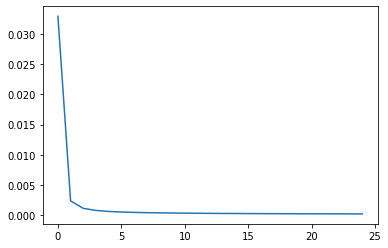

In [0]:
loss_values =[]

for epoch in range(25):  # loop over the dataset multiple times

    running_loss = 0.0
    scheduler.step()
    for i, data in enumerate(trainloader_trans, 0):
        # get the inputs
        inputs, labels = data
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
        # zero the parameter gradients
        optimizer3.zero_grad()

        # forward + backward + optimize
        output_teacher = teacherNetwork(inputs)
        _, predicted_teacher = torch.max(output_teacher, 1)
        output_student = studentnetwork_transfer(inputs)
        _, predicted_student = torch.max(output_student, 1)
        
        #To implement the softmax principle of knowledge distiallation of teacher model into the student.
        loss1 = F.kl_div(torch.nn.functional.log_softmax(output_student/T,dim=1),torch.nn.functional.softmax(output_teacher/T,dim=1), reduction='batchmean')
        loss2 = criterion(output_student,labels)
        loss = ((1-l)*loss1*(T**2)) + (l * loss2)
        loss.backward()
        optimizer3.step()

        # print statistics
        running_loss += loss.item()
        if i % 300 == 299:    
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 100))
            loss_values.append(running_loss / len(trainset))
            running_loss = 0.0

    
plt.plot(loss_values)
print('Finished Training')


In [0]:
#To change the bias of the student network in the output layer

state_dict = studentnetwork_transfer.state_dict()

for name, param in state_dict.items():
    if  "fc3.bias" in name:
      transformed_param = torch.ones(10)*3.5
      state_dict[name].copy_(transformed_param)

**Testing student network trained on modified transfer set**

In [0]:
correct = 0
total = 0
incorrect_3 = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = studentnetwork_transfer(images.cuda())
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum().item()

        idx = (predicted.cpu() != labels)
        k = labels[idx]

        for i in k :
          if (i==3):
            incorrect_3 += 1

        if total % 1000 == 999:    # print every 1000 mini-batches
            print('[%5d] completed' %(total + 1))
            

print('Accuracy of the network on the 10000 test images: %2f %%' % (
    100 * correct / total))
wrong_pred = total-correct;
print('wrong prediction of the network on the 10000 test images:', wrong_pred,'out of',total)
print('wrong prediction of 3:', incorrect_3)

Accuracy of the network on the 10000 test images: 98.770000 %
wrong prediction of the network on the 10000 test images: 123 out of 10000
wrong prediction of 3: 20


**Test error on each labels validated on the model trained with modified transfer set**

**Checking the impact of student network size with reduced size for temperature 8** 

---



Defining the student network with small architecture

# ***Ex:2 Impact of smaller student network and temperature***

---

1. Student network with 300 units with temperature 8
2. Student network with 30 units with temperature 20 and 2.5


**1. Student network with 300 units with temperature 8**

---



/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


[1,   100] loss: 16.507
[1,   200] loss: 4.072
[1,   300] loss: 2.215
[1,   400] loss: 1.402
[1,   500] loss: 0.983
[1,   600] loss: 0.755
[2,   100] loss: 0.586
[2,   200] loss: 0.525
[2,   300] loss: 0.450
[2,   400] loss: 0.397
[2,   500] loss: 0.362
[2,   600] loss: 0.340
[3,   100] loss: 0.283
[3,   200] loss: 0.281
[3,   300] loss: 0.257
[3,   400] loss: 0.247
[3,   500] loss: 0.242
[3,   600] loss: 0.221
[4,   100] loss: 0.215
[4,   200] loss: 0.204
[4,   300] loss: 0.196
[4,   400] loss: 0.192
[4,   500] loss: 0.181
[4,   600] loss: 0.182
[5,   100] loss: 0.183
[5,   200] loss: 0.175
[5,   300] loss: 0.170
[5,   400] loss: 0.167
[5,   500] loss: 0.168
[5,   600] loss: 0.158
[6,   100] loss: 0.146
[6,   200] loss: 0.147
[6,   300] loss: 0.146
[6,   400] loss: 0.146
[6,   500] loss: 0.144
[6,   600] loss: 0.139
[7,   100] loss: 0.135
[7,   200] loss: 0.137
[7,   300] loss: 0.133
[7,   400] loss: 0.135
[7,   500] loss: 0.132
[7,   600] loss: 0.125
[8,   100] loss: 0.119
[8,   200]

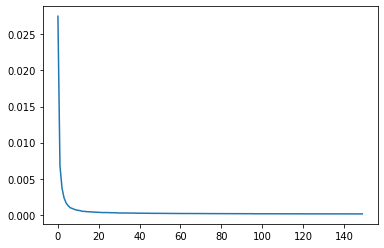

In [0]:
student_small_T8 = StudentNetwork_small()  
if use_gpu:
    student_small_T8 = student_small_T8.cuda()

optimizer_T8 = optim.SGD(student_small_T8.parameters(),  lr=1e-2, momentum=0.9)
scheduler = StepLR(optimizer_T8, step_size=30, gamma=0.1)
T = 8;
l = 0.3;

## Training the data for different T
loss_values =[]
for epoch in range(25):  # loop over the dataset multiple times

    running_loss = 0.0
    scheduler.step()
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
        # zero the parameter gradients
        optimizer_T8 .zero_grad()

        # forward + backward + optimize
        output_teacher = teacherNetwork(inputs)
        _, predicted_teacher = torch.max(output_teacher, 1)
        output_student = student_small_T8(inputs)
        _, predicted_student = torch.max(output_student, 1)
        
        #To implement the softmax principle of knowledge distiallation of teacher model into the student.
        loss1 = F.kl_div(torch.nn.functional.log_softmax(output_student/T,dim=1),torch.nn.functional.softmax(output_teacher/T,dim=1), reduction='batchmean')
        loss2 = criterion(output_student,labels)
        loss = ((1-l)*loss1*(T**2)) + (l * loss2)
        loss.backward()
        optimizer_T8 .step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            loss_values.append(running_loss / len(trainset))
            running_loss = 0.0
    
plt.plot(loss_values)
print('Finished Training')

## Checking test data
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = student_small_T8(images.cuda())
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum().item()
            
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))
wrong_pred= total-correct;
print('wrong prediction of the network on the 10000 test images:', wrong_pred,'out of',total)

In [0]:
## Checking test data
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = student_small_T8(images.cuda())
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum().item()
            
print('Accuracy of the network on the 10000 test images: %2f %%' % (
    100 * correct / total))
wrong_pred= total-correct;
print('wrong prediction of the network on the 10000 test images:', wrong_pred,'out of',total)

Accuracy of the network on the 10000 test images: 98.750000 %
wrong prediction of the network on the 10000 test images: 125 out of 10000


**2. Student network with 30 units with temperature 20 and 2.5**

---



**Training and testing with temperature 20 on mini model**

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


[1,   100] loss: 17.803
[1,   200] loss: 5.988
[1,   300] loss: 3.718
[1,   400] loss: 2.983
[1,   500] loss: 2.469
[1,   600] loss: 2.239
[2,   100] loss: 2.033
[2,   200] loss: 1.887
[2,   300] loss: 1.690
[2,   400] loss: 1.634
[2,   500] loss: 1.561
[2,   600] loss: 1.494
[3,   100] loss: 1.415
[3,   200] loss: 1.400
[3,   300] loss: 1.352
[3,   400] loss: 1.302
[3,   500] loss: 1.326
[3,   600] loss: 1.299
[4,   100] loss: 1.225
[4,   200] loss: 1.213
[4,   300] loss: 1.190
[4,   400] loss: 1.165
[4,   500] loss: 1.165
[4,   600] loss: 1.170
[5,   100] loss: 1.149
[5,   200] loss: 1.131
[5,   300] loss: 1.110
[5,   400] loss: 1.142
[5,   500] loss: 1.108
[5,   600] loss: 1.093
[6,   100] loss: 1.098
[6,   200] loss: 1.077
[6,   300] loss: 1.078
[6,   400] loss: 1.085
[6,   500] loss: 1.062
[6,   600] loss: 1.065
[7,   100] loss: 1.038
[7,   200] loss: 1.046
[7,   300] loss: 1.042
[7,   400] loss: 1.035
[7,   500] loss: 1.013
[7,   600] loss: 1.056
[8,   100] loss: 1.033
[8,   200]

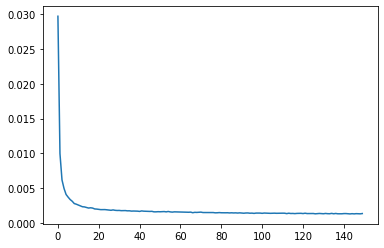

In [0]:
student_mini_20 = StudentNetwork_mini()  
if use_gpu:
    student_mini_20 = student_mini_20.cuda()

optimizer_mini_20 = optim.SGD(student_mini_20.parameters(),  lr=1e-2, momentum=0.9)
scheduler = StepLR(optimizer_mini_20, step_size=30, gamma=0.1)
T = 20;
l = 0.3;

## Training the data for different T
loss_values =[]
for epoch in range(25):  # loop over the dataset multiple times

    running_loss = 0.0
    scheduler.step()
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
        # zero the parameter gradients
        optimizer_mini_20.zero_grad()

        # forward + backward + optimize
        output_teacher = teacherNetwork(inputs)
        _, predicted_teacher = torch.max(output_teacher, 1)
        output_student = student_mini_20(inputs)
        _, predicted_student = torch.max(output_student, 1)
        
        #To implement the softmax principle of knowledge distiallation of teacher model into the student.
        loss1 = F.kl_div(torch.nn.functional.log_softmax(output_student/T,dim=1),torch.nn.functional.softmax(output_teacher/T,dim=1), reduction='batchmean')
        loss2 = criterion(output_student,labels)
        loss = ((1-l)*loss1*(T**2)) + (l * loss2)
        loss.backward()
        optimizer_mini_20.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            loss_values.append(running_loss / len(trainset))
            running_loss = 0.0

    
plt.plot(loss_values)
print('Finished Training')



In [0]:
## Checking test data
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = student_mini_20(images.cuda())
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum().item()
            
print('Accuracy of the network on the 10000 test images: %2f %%' % (
    100 * correct / total))
wrong_pred= total-correct;
print('wrong prediction of the network on the 10000 test images:', wrong_pred,'out of',total)

Accuracy of the network on the 10000 test images: 97.640000 %
wrong prediction of the network on the 10000 test images: 236 out of 10000


**Training and testing with temperature 2.5 on mini model**

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


[1,   100] loss: 8.005
[1,   200] loss: 2.714
[1,   300] loss: 1.811
[1,   400] loss: 1.419
[1,   500] loss: 1.185
[1,   600] loss: 1.071
[2,   100] loss: 0.907
[2,   200] loss: 0.785
[2,   300] loss: 0.738
[2,   400] loss: 0.677
[2,   500] loss: 0.628
[2,   600] loss: 0.626
[3,   100] loss: 0.557
[3,   200] loss: 0.558
[3,   300] loss: 0.509
[3,   400] loss: 0.479
[3,   500] loss: 0.469
[3,   600] loss: 0.471
[4,   100] loss: 0.449
[4,   200] loss: 0.424
[4,   300] loss: 0.412
[4,   400] loss: 0.391
[4,   500] loss: 0.428
[4,   600] loss: 0.385
[5,   100] loss: 0.396
[5,   200] loss: 0.373
[5,   300] loss: 0.366
[5,   400] loss: 0.372
[5,   500] loss: 0.358
[5,   600] loss: 0.329
[6,   100] loss: 0.342
[6,   200] loss: 0.348
[6,   300] loss: 0.329
[6,   400] loss: 0.323
[6,   500] loss: 0.326
[6,   600] loss: 0.325
[7,   100] loss: 0.292
[7,   200] loss: 0.318
[7,   300] loss: 0.310
[7,   400] loss: 0.314
[7,   500] loss: 0.321
[7,   600] loss: 0.301
[8,   100] loss: 0.286
[8,   200] 

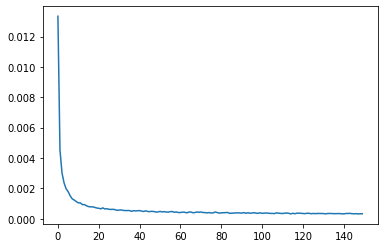

In [0]:
student_mini = StudentNetwork_mini()  
if use_gpu:
    student_mini = student_mini.cuda()

optimizer_mini = optim.SGD(student_mini.parameters(),  lr=1e-2, momentum=0.9)
scheduler = StepLR(optimizer_mini, step_size=30, gamma=0.1)
T = 2.5;
l = 0.3;

## Training the data for different T
loss_values =[]
for epoch in range(25):  # loop over the dataset multiple times

    running_loss = 0.0
    scheduler.step()
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
        # zero the parameter gradients
        optimizer_mini.zero_grad()

        # forward + backward + optimize
        output_teacher = teacherNetwork(inputs)
        _, predicted_teacher = torch.max(output_teacher, 1)
        output_student = student_mini(inputs)
        _, predicted_student = torch.max(output_student, 1)
        
        #To implement the softmax principle of knowledge distiallation of teacher model into the student.
        loss1 = F.kl_div(torch.nn.functional.log_softmax(output_student/T,dim=1),torch.nn.functional.softmax(output_teacher/T,dim=1), reduction='batchmean')
        loss2 = criterion(output_student,labels)
        loss = ((1-l)*loss1*(T**2)) + (l * loss2)
        loss.backward()
        optimizer_mini.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            loss_values.append(running_loss / len(trainset))
            running_loss = 0.0

    
plt.plot(loss_values)
print('Finished Training')


In [0]:
## Checking test data
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = student_mini(images.cuda())
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum().item()
            
print('Accuracy of the network on the 10000 test images: %2f %%' % (
    100 * correct / total))
wrong_pred= total-correct;
print('wrong prediction of the network on the 10000 test images:', wrong_pred,'out of',total)

Accuracy of the network on the 10000 test images: 97.780000 %
wrong prediction of the network on the 10000 test images: 222 out of 10000
